# Finger Anomaly Detection Model 

In [10]:
import os
import numpy as np
import pandas as pd
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,MaxPooling2D,Flatten,Dropout
from keras import regularizers
from keras.optimizers import Adam, Adadelta
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.models import model_from_json
import itertools
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16,preprocess_input,decode_predictions
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input
from keras.models import  Sequential
from sklearn import metrics

%matplotlib inline

## Loading the data

In [5]:
finger_df = pd.read_csv('train_finger.csv')
finger_test = pd.read_csv('test_finger.csv')

### For GPU  

In [386]:
# K.tensorflow_backend._get_available_gpus()
# assert len(K.tensorflow_backend._get_available_gpus()) > 0

## Class weights

In [387]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(finger_df['class_label']), finger_df['class_label'])

In [388]:
class_weights

array([0.81357553, 1.2972561 ])

## Generating Train, Validation, Test Data

In [6]:
datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
#     featurewise_center = True,
#     featurewise_std_normalization = True,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.1)

In [7]:
train_generator = datagen.flow_from_dataframe(
    dataframe = finger_df,
    directory = None,
    x_col = "path",
    y_col = "class_label",
    subset = "training",
    batch_size = 8,
    shuffle = True,
    class_mode = "categorical",
    target_size = (224, 224))

valid_generator = datagen.flow_from_dataframe(
    dataframe = finger_df,
    directory = None,
    x_col = "path",
    y_col = "class_label",
    subset = "validation",
    batch_size = 8,
    shuffle = True,
    class_mode = "categorical",
    target_size = (224, 224))

Found 4596 validated image filenames belonging to 2 classes.
Found 510 validated image filenames belonging to 2 classes.


In [8]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=finger_test,
directory=None,
x_col="path",
y_col='class_label',
batch_size=8,
shuffle=False,
target_size=(224, 224))

Found 461 validated image filenames belonging to 2 classes.


## MobileNet Model

In [392]:
# mobile = MobileNet()
# x = mobile.layers[-6].output
# predictions = Dense(2, activation='softmax')(x)
# model = Model(inputs=mobile.input, outputs=predictions)

# x = model.layers[-2].output
# x = Dense(1024, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)

# predictions = Dense(2, activation='softmax')(x)

# model = Model(inputs=model.input, outputs=predictions)

In [393]:
# for layer in model.layers[:]:
#    layer.trainable = False

In [394]:
# for layer in model.layers[:-6]:
#    layer.trainable = True

## Inception V3 Model

In [423]:
# Instantiating the model & customizing the layers
input_tensor = Input(shape=(224, 224, 3))
model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False, )

x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)

predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)

In [424]:
# Freezing layers for training 
for layer in model.layers[:249]:
   layer.trainable = False

In [425]:
# Unfreezing layers for training 
for layer in model.layers[-7:]:
   layer.trainable = True

## Compiling and training the model

In [426]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [438]:
model.fit_generator(train_generator, steps_per_epoch=163, 
                    validation_data=valid_generator, 
                    validation_steps=21, class_weight = class_weights,
                    epochs=8, verbose=1)

Epoch 1/8
163/163 [==============================] - 20s 124ms/step - loss: 0.4645 - acc: 0.7715 - val_loss: 0.8050 - val_acc: 0.5357
Epoch 2/8
163/163 [==============================] - 19s 118ms/step - loss: 0.4686 - acc: 0.7807 - val_loss: 0.9879 - val_acc: 0.3614
Epoch 3/8
163/163 [==============================] - 19s 117ms/step - loss: 0.4542 - acc: 0.7876 - val_loss: 1.4697 - val_acc: 0.3274
Epoch 4/8
163/163 [==============================] - 19s 116ms/step - loss: 0.4495 - acc: 0.7799 - val_loss: 0.7871 - val_acc: 0.6250
Epoch 5/8
163/163 [==============================] - 19s 117ms/step - loss: 0.4736 - acc: 0.7684 - val_loss: 1.1764 - val_acc: 0.2590
Epoch 6/8
163/163 [==============================] - 19s 117ms/step - loss: 0.4614 - acc: 0.7837 - val_loss: 1.0822 - val_acc: 0.2976
Epoch 7/8
163/163 [==============================] - 19s 118ms/step - loss: 0.4840 - acc: 0.7623 - val_loss: 0.9253 - val_acc: 0.2798
Epoch 8/8
163/163 [==============================] - 19s 117ms

## Scoring the model

In [13]:
with open('flask/models/XR_FINGER_mf.json', 'r') as f:
    finger_model = model_from_json(f.read())
    finger_model.load_weights('flask/models/XR_FINGER_mf.h5')

In [14]:
# Test the model on the test set
Y_pred = finger_model.predict_generator(test_generator, steps=round(test_generator.n/8), verbose=1)

58/58 [==============================] - 33s 564ms/step


In [15]:
# Get the correct guesses
test_labels = test_generator.classes

In [16]:
matrix = confusion_matrix(test_labels, Y_pred.argmax(axis=1))
matrix

array([[153,  61],
       [ 66, 181]])

In [17]:
# Metrics for the model
print(metrics.classification_report(test_labels, Y_pred.argmax(axis=1), digits=3))

              precision    recall  f1-score   support

           0      0.699     0.715     0.707       214
           1      0.748     0.733     0.740       247

    accuracy                          0.725       461
   macro avg      0.723     0.724     0.723       461
weighted avg      0.725     0.725     0.725       461



In [18]:
test_classes = test_generator.class_indices
tc = np.array(list(test_classes.keys()))

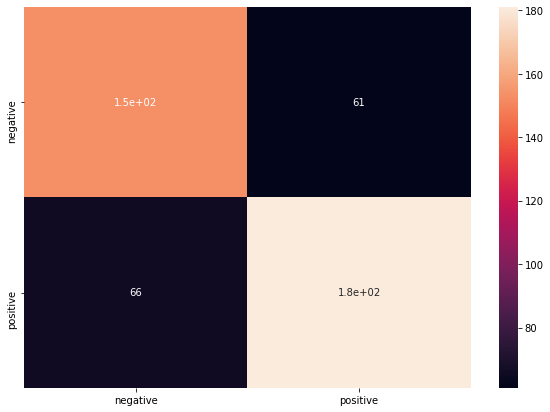

In [19]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(matrix, index = [i for i in tc],
                  columns = [i for i in tc])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [405]:
# Saving the model
with open('models/XR_FINGER_v2.json', 'w') as f:
    f.write(model.to_json())

# Saving the model weights
model.save_weights("models/XR_FINGER_v2.h5")